<a href="https://colab.research.google.com/github/wtrlili/Spoon-Knife/blob/main/Cats_and_Dogs_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
from PIL import Image
import cv2
import random
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import OrderedDict
import torchvision.utils as utils
from sklearn.metrics import accuracy_score, f1_score

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_SIZE = 224
AUGMENTATION_NUM = 5
EPOCHES = 80
BATCH_SIZE = 32 # the best among 16, 32, 64

In [ ]:
dataset = []
label = []

resize_transform = T.Resize((IMG_SIZE,IMG_SIZE))

path = "./drive/MyDrive/Deep Learning/cropped_cats"
dir_list = os.listdir(path)

for i in dir_list:
    cat = Image.open(path+'/'+str(i))
    cat = resize_transform(cat)
    cat = image.img_to_array(cat)
    cat = cat / 255.0
    dataset.append(cat)
    label.append(0)

In [ ]:
dataset[0].shape

(224, 224, 3)

In [ ]:
path = "./drive/MyDrive/Deep Learning/cropped_dogs"
dir_list = os.listdir(path)

for i in dir_list:
    dog = Image.open(path+'/'+str(i))
    dog = resize_transform(dog)
    dog = image.img_to_array(dog)
    dog = dog / 255.0
    dataset.append(dog)
    label.append(1)

In [ ]:
dataset = np.array(dataset)
label = np.array(label)

length = len(label)
indexes = list(range(length))
random.shuffle(indexes)
num = int(length*0.7)
num_val = int(length*0.85)
indexes_train = indexes[:num]
indexes_validation = indexes[num:num_val]
indexes_test = indexes[num_val:]

train_X = dataset[indexes_train]
validation_X = dataset[indexes_validation]
test_X = dataset[indexes_test]

train_y = label[indexes_train]
validation_y = label[indexes_validation]
test_y = label[indexes_test]

In [ ]:
train_X = torch.Tensor(np.array(train_X))
validation_X = torch.Tensor(np.array(validation_X))
test_X = torch.Tensor(np.array(test_X))

train_y = torch.Tensor(np.array(train_y))
validation_y = torch.Tensor(np.array(validation_y))
test_y = torch.Tensor(np.array(test_y))

In [ ]:
train_images_loader = DataLoader(list(zip(train_X,train_y)), batch_size=BATCH_SIZE, shuffle=True)
validation_images_loader = DataLoader(list(zip(validation_X,validation_y)), batch_size=BATCH_SIZE, shuffle=True)
test_images_loader = DataLoader(list(zip(test_X,test_y)), batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
base_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
base_model.eval()

In [ ]:
classify_model = nn.Sequential(OrderedDict([
		("hidden_layer_1_cd", nn.Linear(1000, 32)),
		("activation_1_cd", nn.ReLU()),
		("output_layer_cd", nn.Linear(32, 2)),
		("activation_2_cd", nn.LeakyReLU())
	]))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classify_model.parameters(), lr=0.00001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base_model.to(device)
classify_model.to(device)

In [ ]:
total_losses_train = []
total_losses_test = []

total_accuracy_train = []
total_accuracy_test = []

total_f1score_train = []
total_f1score_test = []

for epoch in range(EPOCHES):
    print("epoch:", epoch)

    # TRAIN
    classify_model.train()

    real_label_list = []
    losses_list = []
    predictions_list = []

    for input, label in train_images_loader:

        input = input.to(device).float()
        input = torch.reshape(input, (len(input), 3, IMG_SIZE, IMG_SIZE))

        label = label.to(device).float()
        one_hot_label = nn.functional.one_hot(label.view(-1).to(torch.int64), 2).float()

        optimizer.zero_grad()
        base_outputs = base_model(input)
        outputs = classify_model(base_outputs).float()

        loss = criterion(outputs, one_hot_label)
        losses_list.append(loss.item())

        prediction = torch.max(outputs, 1)[1]
        real_label_list.extend(label)
        predictions_list.extend(prediction)

        loss.backward()
        optimizer.step()

    # calculate average train loss and accuracy for epoch
    training_loss = sum(losses_list)/len(losses_list)
    total_losses_train.append(training_loss)
    real_label_list = torch.stack(real_label_list, dim=0)
    predictions_list = torch.stack(predictions_list, dim=0)

    # calculate score
    training_acc = accuracy_score(real_label_list.squeeze().cpu().data.squeeze().numpy(), predictions_list.cpu().data.squeeze().numpy())
    total_accuracy_train.append(training_acc)
    training_f1 = f1_score(real_label_list.squeeze().cpu().data.squeeze().numpy(), predictions_list.cpu().data.squeeze().numpy(), average='macro')
    total_f1score_train.append(training_f1)
    print("Training Loss of Epoch {}: {:.6f} | Accuracy: {:.2f}% | F1 Score {:.2f}".format(epoch+1, training_loss, training_acc*100, training_f1))


    # TEST
    classify_model.eval()

    real_label_list = []
    losses_list = []
    predictions_list = []

    with torch.no_grad():
        for input, label in validation_images_loader:
            # get the inputs and labels
            input = input.to(device).float()
            input = torch.reshape(input, (len(input), 3, IMG_SIZE, IMG_SIZE))

            label = label.to(device).float()
            one_hot_label = nn.functional.one_hot(label.view(-1).to(torch.int64), 2).float()

            base_outputs = base_model(input)
            outputs = classify_model(base_outputs).float()

            # calculate loss
            loss = criterion(outputs, one_hot_label)
            losses_list.append(loss.item())

            prediction = torch.max(outputs, 1)[1]
            real_label_list.extend(label)
            predictions_list.extend(prediction)

    # calculate average test loss and accuracy for epoch
    test_loss = sum(losses_list)/len(losses_list)
    total_losses_test.append(test_loss)
    real_label_list = torch.stack(real_label_list, dim=0)
    predictions_list = torch.stack(predictions_list, dim=0)

    # calculate score
    test_acc = accuracy_score(real_label_list.squeeze().cpu().data.squeeze().numpy(), predictions_list.cpu().data.squeeze().numpy())
    total_accuracy_test.append(test_acc)
    test_f1 = f1_score(real_label_list.squeeze().cpu().data.squeeze().numpy(), predictions_list.cpu().data.squeeze().numpy(), average='macro')
    total_f1score_test.append(test_f1)
    print("Test Loss of Epoch: {:.6f} | Accuracy: {:.2f}% | F1 Score {:.2f}".format(test_loss, test_acc*100, test_f1))


epoch: 0
Training Loss of Epoch 1: 0.706566 | Accuracy: 41.43% | F1 Score 0.37
Test Loss of Epoch: 0.695677 | Accuracy: 53.33% | F1 Score 0.50
epoch: 1
Training Loss of Epoch 2: 0.699553 | Accuracy: 44.29% | F1 Score 0.42
Test Loss of Epoch: 0.697078 | Accuracy: 56.67% | F1 Score 0.54
epoch: 2
Training Loss of Epoch 3: 0.697648 | Accuracy: 45.71% | F1 Score 0.45
Test Loss of Epoch: 0.697174 | Accuracy: 56.67% | F1 Score 0.54
epoch: 3
Training Loss of Epoch 4: 0.694906 | Accuracy: 47.14% | F1 Score 0.47
Test Loss of Epoch: 0.696135 | Accuracy: 60.00% | F1 Score 0.58
epoch: 4
Training Loss of Epoch 5: 0.692229 | Accuracy: 46.43% | F1 Score 0.46
Test Loss of Epoch: 0.695513 | Accuracy: 63.33% | F1 Score 0.63
epoch: 5
Training Loss of Epoch 6: 0.690876 | Accuracy: 48.57% | F1 Score 0.48
Test Loss of Epoch: 0.694573 | Accuracy: 60.00% | F1 Score 0.60
epoch: 6
Training Loss of Epoch 7: 0.691994 | Accuracy: 50.71% | F1 Score 0.49
Test Loss of Epoch: 0.693635 | Accuracy: 56.67% | F1 Score 0.57

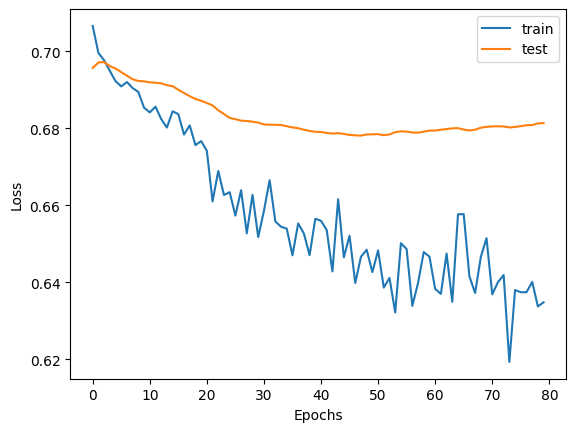

In [ ]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(total_losses_train, label="train")
plt.plot(total_losses_test, label="test")
plt.legend()
plt.show()

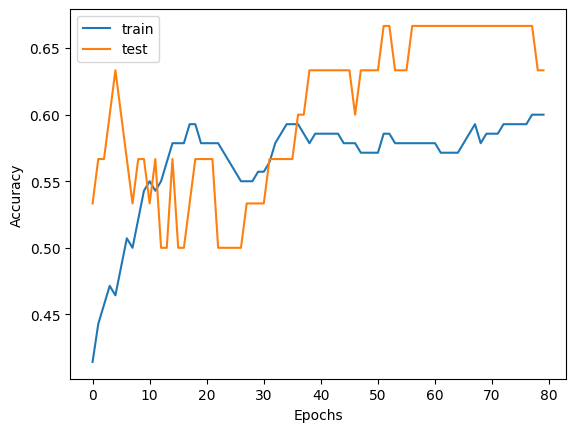

In [ ]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(total_accuracy_train, label="train")
plt.plot(total_accuracy_test, label="test")
plt.legend()
plt.show()

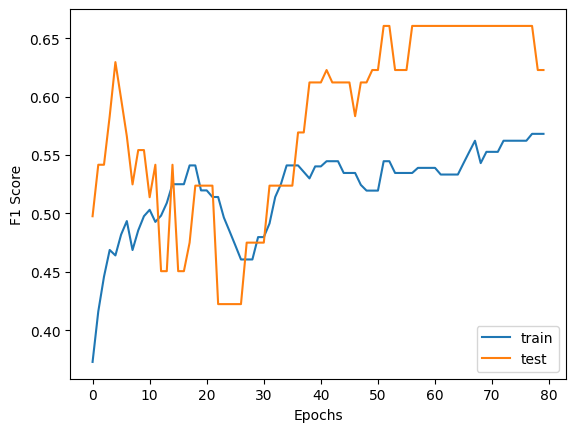

In [ ]:
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.plot(total_f1score_train, label="train")
plt.plot(total_f1score_test, label="test")
plt.legend()
plt.show()